# Setting up a latent function Gaussian Process for H(z)

In [110]:
# import set 
using Turing
using Distances
using LinearAlgebra
using LimberJack
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals

### Collate data

In [111]:
# setting a cosmology for the fake data, all fiducial cosmo parameters 
cosmo1 = Cosmology();
rd_fid = 99.0792;

# assumed parameter distributions
omegam_dist = Uniform(0.25, 0.35);
h0_dist = Uniform(0.6, 0.8);
s8_dist = Uniform(0.6, 0.9);
rd_dist = Uniform(90, 110);
M_dist = Uniform(0.0, 1.0);

# adaptation and sample steps for GP posterior
nadapts = 10;
nsamp = 50;

#### Generate fake data

In [112]:
# hz data
function fakedata_hz()
z  = sort(2.5 .* rand(30)) # random array of 30 z values sorted ascending (0 - 2.5)
data  = cosmo1.cpar.h*100*Ez(cosmo1, z)
err = 0.1 .* data
cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_hz", z = z, data = data, cov = cov)
end

# chi data
function fakedata_dm()
    z = sort(2.5 .* rand(300))
    data = cosmo1.chi(z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_dm", z = z, data = data, cov = cov)
end

# fs8 data
function fakedata_fs8()
    z = sort([[0.01, 0.02, 0.07] ; (2.5 .* rand(5))])
    data = fs8(cosmo1, z)
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return(data_name = "fakedata_fs8", z = z, data = data, cov = cov)
end

# aiso data
function fakedata_aiso()
z  = sort(2.5 .* rand(12)) 
dvz_cb = ((z .* LimberJack.CLIGHT_HMPC) .* ((cosmo1.chi(z)) .^ 2)) ./ (cosmo1.cpar.h .* 100 .* Ez(cosmo1, z))
data = (dvz_cb .^ (1/3)) ./ rd_fid
err = 0.1 .* data
cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_aiso", z = z, data = data, cov = cov)
end

# aap data
function fakedata_aap()
    z = sort([[0.01, 0.02, 0.03, 0.05, 0.06, 0.07] ; (2.5 .* rand(4))])
    data = LimberJack.CLIGHT_HMPC ./ (cosmo1.cpar.h .* 100 .* Ez(cosmo1, z) .* (cosmo1.chi(z)))
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_aap", z = z, data = data, cov = cov)
end

# supernovae data
function fakedata_mu()
    z = sort([[0.01, 0.02, 0.05, 0.09] ; (2.5 .* rand(4))])
    d_lum = (1 .+ z) .* (cosmo1.chi(z))
    data = 5 .* log10.(d_lum) .+ 25 .+ 0.5
    err = 0.1 .* data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "fakedata_mu", z = z, data = data, cov = cov)
end



fakedatahz = fakedata_hz();
fakedatadm = fakedata_dm();
fakedatafs8 = fakedata_fs8();
fakedataaap = fakedata_aap();
fakedataaiso = fakedata_aiso();
fakedatamu = fakedata_mu();



#### Putting Hz, Dm and fs8 data together

In [113]:
# fake data
data_obs  = [fakedatahz.data; fakedataaiso.data; fakedataaap.data; fakedatafs8.data; fakedatamu.data];
z_obs = [fakedatahz.z; fakedataaiso.z; fakedataaap.z; fakedatafs8.z; fakedatamu.z];
covariance_obs = BlockDiagonal([fakedatahz.cov, fakedataaiso.cov, fakedataaap.cov, fakedatafs8.cov, fakedatamu.cov]);

# correlation matrix
function cov_to_cor(covariance)
    std_devs = sqrt.(diag(covariance))
    return covariance ./ (std_devs * std_devs')
end

correlation_obs = cov_to_cor(covariance_obs)

# # derived covariance
# function corr_to_cov(correlation, scale)

# errors
hz_err = 0.1 .* fakedatahz.data;
aiso_err = 0.1 .* fakedataaiso.data;
aap_err = 0.1 .* fakedataaap.data;
fs8_err = 0.1 .* fakedatafs8.data;
mu_err = 0.1 .* fakedatamu.data;

### Functions for hz, chi and fs8

In [114]:
# outputs are arrays, not interpolators
function hz_from_ez(zarr, h0, ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())
    hz = ez_itp(zarr) .* (h0*100)
    #hzi = linear_interpolation(zarr, hz, extrapolation_bc=Line())
    return hz
end

function dm_from_ez(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    return chis
end


function fs8_from_ez(zarr, Ωm, σ8, h0, ez, cosmo_type)
    # initialising
    nz = length(zarr)
    z_max = maximum(zarr)
    x = log.(1 .+ zarr)
    a = @.(1/(1+zarr))
    dx = x[2]-x[1]
    
    aa = reverse(a)
    ee = reverse(ez)
    dd = zeros(cosmo_type, nz)
    yy = zeros(cosmo_type, nz)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)

    fs8zi =  -σ8 .* y./ (a.^2 .*ez.*d[1])
                                
                        
    return fs8zi
end


function dh(zarr, h0, ez)
    dhz = LimberJack.CLIGHT_HMPC ./ (hz_from_ez(zarr, h0, ez))
    return dhz
end

function dv(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    
    dvs = similar(chis)
    for i in 1:length(zarr)
        zz = zarr[i]
        dvz_cbrt = zz * (LimberJack.CLIGHT_HMPC/(ez_itp(zz)*h0*100)) * (chis[i]^2)
        dvs[i] = sign(dvz_cbrt) * abs(dvz_cbrt)^(1/3)
    end

    return dvs
end

function a_ap(zarr, h0, ez)
  numer = dh(zarr, h0, ez) ./ dm_from_ez(zarr, h0, ez)
  return numer 
end

function a_iso(zarr, h0, rd, ez)
    numer = dv(zarr, h0, ez) ./ rd
    return numer 
end

function d_lum(zarr, h0, ez)
    dlz = (1 .+ zarr) .* dm_from_ez(zarr, h0, ez)
    return dlz
end

function mu(zarr, h0, M, ez)
    muz = 5 .* log10.( abs.(d_lum(zarr, h0, ez)) ) .+ 25 .+ M
    return muz
end

mu (generic function with 1 method)

In [115]:
#z_integ1 = max.(cosmo1.settings.zs, 1e-12);
z_integ1 = cosmo1.settings.zs;
ez_test = Ez(cosmo1, z_integ1);

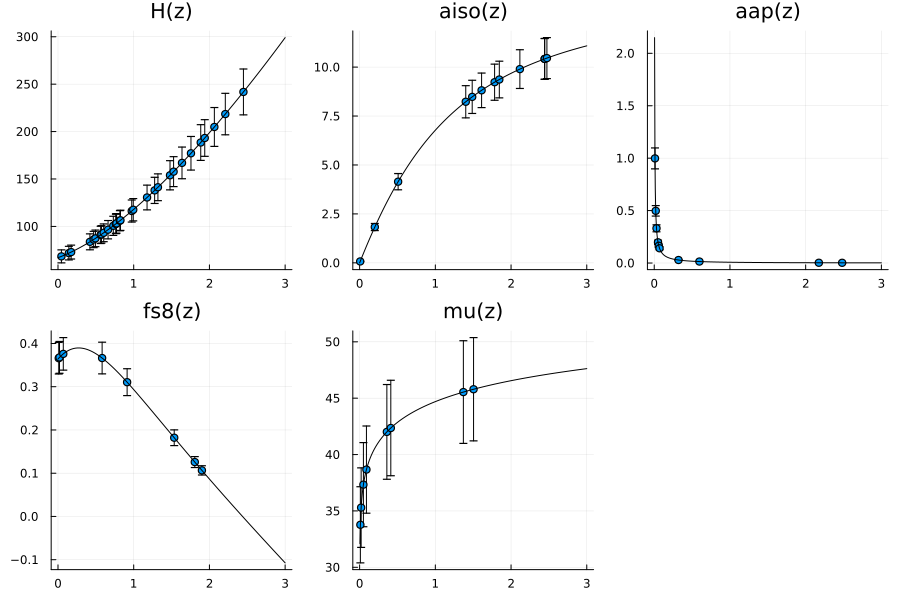

In [116]:
p0 = plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, seriestype=:scatter,title="H(z)", legend=false)
p1 = plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, seriestype=:scatter,title="aiso(z)", legend=false)
p2 = plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, seriestype=:scatter, title="aap(z)", legend=false)
p3 = plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, seriestype=:scatter, title="fs8(z)", legend=false)
p4 = plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, seriestype=:scatter, title="mu(z)", legend=false)

plot!(p0, z_integ1, hz_from_ez(z_integ1, cosmo1.cpar.h, ez_test), color=:black)
plot!(p1, z_integ1, a_iso(z_integ1, cosmo1.cpar.h, rd_fid, ez_test), color=:black)
plot!(p2, z_integ1, a_ap(z_integ1, cosmo1.cpar.h, ez_test), color=:black)
plot!(p3, z_integ1, fs8_from_ez(z_integ1, cosmo1.cpar.Ωm, cosmo1.cpar.σ8, cosmo1.cpar.h, ez_test, eltype(ez_test)), color=:black)
plot!(p4, z_integ1, mu(z_integ1, cosmo1.cpar.h, 0.5, ez_test), color=:black)

plot(p0, p1, p2, p3, p4, layout=(2,3), size=(900,600))

## LCDM analysis

In [117]:
@model function LCDM_model(data, data_cov)
    # Priors
    omegam_pr ~ omegam_dist
    h0_pr ~ h0_dist
    s8_pr ~ s8_dist
    rd_pr ~ rd_dist
    M_pr ~ M_dist

    # Create cosmology
    cosmo_pr = LimberJack.Cosmology(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_pr);
    
    # Model predictions
    ez_model = Ez(cosmo_pr, z_integ1)
    hz_model = hz_from_ez(z_integ1, h0_pr, ez_model)
    dv_rd_model = a_iso(z_integ1, h0_pr, rd_pr, ez_model) 
    dh_dm_model = a_ap(z_integ1, h0_pr, ez_model)
    fs8_model = fs8_from_ez(z_integ1, omegam_pr, s8_pr, h0_pr, ez_model, eltype(ez_model))
    mu_model = mu(z_integ1, h0_pr, M_pr, ez_model)

    # Create interpolators
    hz_itp = LinearInterpolation(z_integ1, hz_model, extrapolation_bc=Line())
    dvrd_itp = LinearInterpolation(z_integ1, dv_rd_model, extrapolation_bc=Line())
    dhdm_itp = LinearInterpolation(z_integ1, dh_dm_model, extrapolation_bc=Line())
    fs8_itp = LinearInterpolation(z_integ1, fs8_model, extrapolation_bc=Line())
    mu_itp = LinearInterpolation(z_integ1, mu_model, extrapolation_bc=Line())

    hz_theory := hz_itp(fakedatahz.z)
    dvrd_theory := dvrd_itp(fakedataaiso.z)
    dhdm_theory := dhdm_itp(fakedataaap.z)
    fs8_theory := fs8_itp(fakedatafs8.z)
    mu_theory := mu_itp(fakedatamu.z)

    theory = [hz_theory; dvrd_theory; dhdm_theory; fs8_theory; mu_theory]

    # Likelihood
    data ~ MvNormal(theory, data_cov)
end

LCDM_model (generic function with 2 methods)

In [118]:
cond_LCDM_model = LCDM_model(data_obs, covariance_obs)
chain_LCDM = sample(cond_LCDM_model, NUTS(10, 0.65), 50)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   2%|▊                                         |  ETA: 0:04:04
Sampling   3%|█▍                                        |  ETA: 0:02:03
Sampling   5%|██▏                                       |  ETA: 0:01:21
Sampling   7%|██▊                                       |  ETA: 0:01:01
Sampling   8%|███▌                                      |  ETA: 0:00:49
Sampling  10%|████▎                                     |  ETA: 0:00:41
Sampling  12%|████▉                                     |  ETA: 0:00:36
Sampling  13%|█████▋                                    |  ETA: 0:00:32
Sampling  15%|██████▎                                   |  ETA: 0:00:28
Sampling  17%|███████                                   |  ETA: 0:00:28
Sampling  18%|███████▊                                  |  ETA: 0:00:25
Sampling  20%|█

Chains MCMC chain (50×85×1 Array{Float64, 3}):

Iterations        = 11:1:60
Number of chains  = 1
Samples per chain = 50
Wall duration     = 12.94 seconds
Compute duration  = 12.94 seconds
parameters        = omegam_pr, h0_pr, s8_pr, rd_pr, M_pr, hz_theory[1], hz_theory[2], hz_theory[3], hz_theory[4], hz_theory[5], hz_theory[6], hz_theory[7], hz_theory[8], hz_theory[9], hz_theory[10], hz_theory[11], hz_theory[12], hz_theory[13], hz_theory[14], hz_theory[15], hz_theory[16], hz_theory[17], hz_theory[18], hz_theory[19], hz_theory[20], hz_theory[21], hz_theory[22], hz_theory[23], hz_theory[24], hz_theory[25], hz_theory[26], hz_theory[27], hz_theory[28], hz_theory[29], hz_theory[30], dvrd_theory[1], dvrd_theory[2], dvrd_theory[3], dvrd_theory[4], dvrd_theory[5], dvrd_theory[6], dvrd_theory[7], dvrd_theory[8], dvrd_theory[9], dvrd_theory[10], dvrd_theory[11], dvrd_theory[12], dhdm_theory[1], dhdm_theory[2], dhdm_theory[3], dhdm_theory[4], dhdm_theory[5], dhdm_theory[6], dhdm_theory[7], dhdm_

In [119]:
# lcdm chains
hzdata_lcdm = group(chain_LCDM, :hz_theory).value.data[:,:,1];
aisodata_lcdm = group(chain_LCDM, :dvrd_theory).value.data[:,:,1];
aapdata_lcdm = group(chain_LCDM, :dhdm_theory).value.data[:,:,1];
fs8data_lcdm = group(chain_LCDM, :fs8_theory).value.data[:,:,1];
mudata_lcdm = group(chain_LCDM, :mu_theory).value.data[:,:,1];

# mean and standard deviation - lcdm
hz_lcdm_m, hz_lcdm_s = mean(hzdata_lcdm, dims=1), std(hzdata_lcdm, dims=1); 
aiso_lcdm_m, aiso_lcdm_s = mean(aisodata_lcdm, dims=1), std(aisodata_lcdm, dims=1);
aap_lcdm_m, aap_lcdm_s = mean(aapdata_lcdm, dims=1), std(aapdata_lcdm, dims=1); 
fs8_lcdm_m, fs8_lcdm_s = mean(fs8data_lcdm, dims=1), std(fs8data_lcdm, dims=1); 
mu_lcdm_m, mu_lcdm_s = mean(mudata_lcdm, dims=1), std(mudata_lcdm, dims=1); 

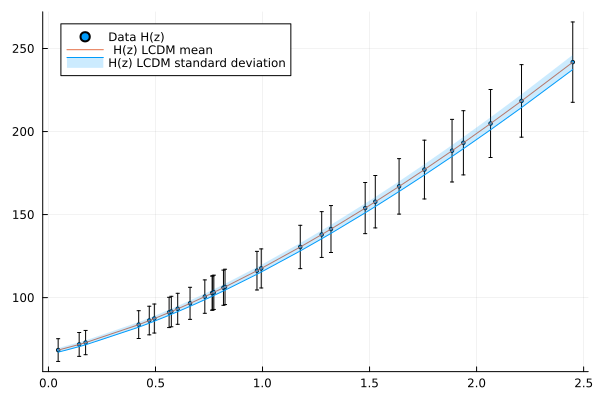

In [120]:
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data H(z)", ms=2, seriestype=:scatter)
plot!(fakedatahz.z, vec(hz_lcdm_m), label=" H(z) LCDM mean")
plot!(fakedatahz.z, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="H(z) LCDM standard deviation")

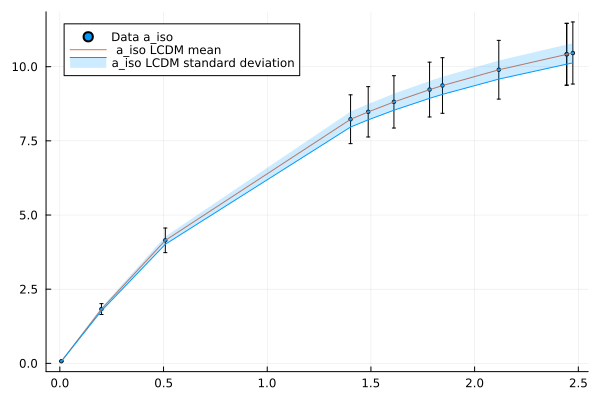

In [121]:
plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, label="Data a_iso", ms=2, seriestype=:scatter)
plot!(fakedataaiso.z, vec(aiso_lcdm_m), label=" a_iso LCDM mean")
plot!(fakedataaiso.z, vec(aiso_lcdm_m .- aiso_lcdm_s),  fillrange = vec(aiso_lcdm_m .+ aiso_lcdm_s), fillalpha=0.2, c=1, label="a_iso LCDM standard deviation")

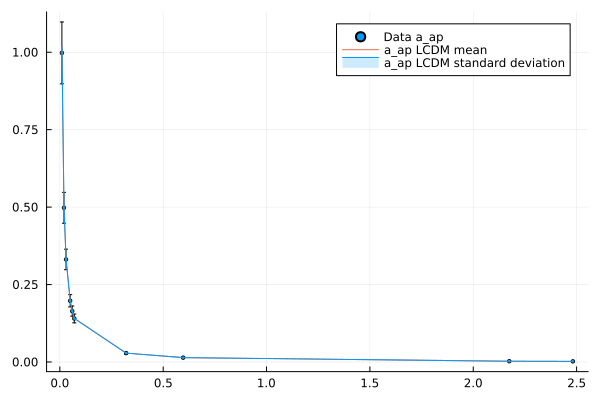

In [122]:
plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, label="Data a_ap", ms=2, seriestype=:scatter)
plot!(fakedataaap.z, vec(aap_lcdm_m), label="a_ap LCDM mean")
plot!(fakedataaap.z, vec(aap_lcdm_m .- aap_lcdm_s),  fillrange = vec(aap_lcdm_m .+ aap_lcdm_s), fillalpha=0.2, c=1, label="a_ap LCDM standard deviation")

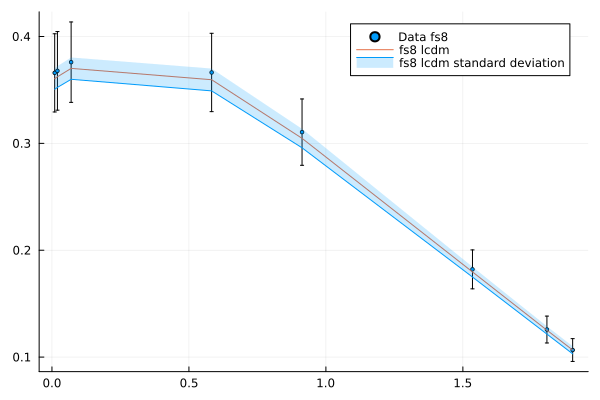

In [123]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8_lcdm_m), label="fs8 lcdm")
plot!(fakedatafs8.z, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=1, label="fs8 lcdm standard deviation")

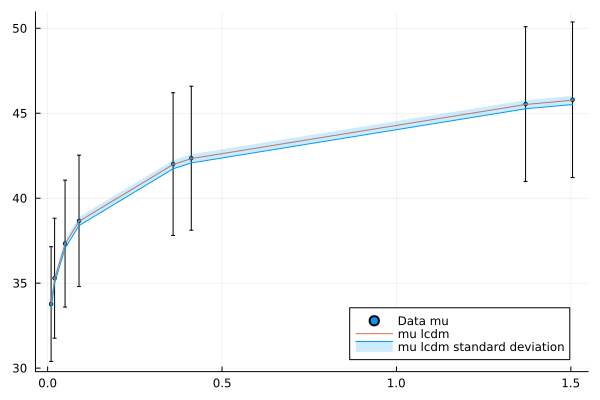

In [124]:
plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, label="Data mu", ms=2, seriestype=:scatter)
plot!(fakedatamu.z, vec(mu_lcdm_m), label="mu lcdm")
plot!(fakedatamu.z, vec(mu_lcdm_m .- mu_lcdm_s),  fillrange = vec(mu_lcdm_m .+ mu_lcdm_s), fillalpha=0.2, c=1, label="mu lcdm standard deviation")

## GP modelling - priors

In [125]:
zlat = range(0, 3.0, length=30); # latent variable space
z_integ = cosmo1.settings.zs; # integral variable space

In [126]:
function model_latent_GP(eta, l, v; omega_m=cosmo1.cpar.Ωm, sigma_8=cosmo1.cpar.σ8, h_0 = cosmo1.cpar.h,
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omega_m,  Ωb=cosmo1.cpar.Ωb, h=h_0, σ8=sigma_8)
    mean_ex = Ez(cpar, x)
    # a latent GP is carried out using a Wiener filter
    ex = latent_GP(mean_ex, v, kernel)
    # transforms hx from x space to z space
    ez =  conditional(x, z, ex, sqexp_cov_fn;
                     eta=eta, l=l)
    return ex, ez
end

model_latent_GP (generic function with 1 method)

hx is the GP realisation of the hubble parameter. hz transforms hx from the latent space to another parameter space (integral or observation).

In [127]:
N_samples = 100
# data parameter space conditional
exs1=zeros(N_samples, 30) #latent variable chain
ezs1=zeros(N_samples, length(z_obs)) #observed variable chain
# pick 100 random hyperparameter combinations, and compute the GP realisation of them in both latent and conditional space.
for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    exs1[i, :], ezs1[i, :] = model_latent_GP(0.1, 0.3, v)
end
y_m1, y_s1 = mean(ezs1, dims=1), std(ezs1, dims=1); #observed space
gp_m1, gp_s1 = mean(exs1, dims=1), std(exs1, dims=1); #latent space


In [128]:
# integral parameter space conditional
exs2=zeros(N_samples, length(zlat))
ezs2=zeros(N_samples, length(z_integ))
hz_pr=zeros(N_samples, length(z_integ))
aiso_pr=zeros(N_samples, length(z_integ))
aap_pr=zeros(N_samples, length(z_integ))
fs8_pr=zeros(N_samples, length(z_integ))
mu_pr=zeros(N_samples, length(z_integ))

for i in 1:N_samples
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    h_pr = rand(h0_dist)
    s8_pr = rand(s8_dist)
    omegam_pr = rand(omegam_dist)
    rd_pr = rand(rd_dist)
    M_pr = rand(M_dist)

    exs2[i, :], ezs2[i, :] = model_latent_GP(0.1, 0.3, v; z=z_integ, sigma_8=s8_pr)
    hz_pr[i, :] = hz_from_ez(z_integ, h_pr, ezs2[i, :])
    aiso_pr[i, :] = a_iso(z_integ, h_pr, rd_pr, ezs2[i, :])
    aap_pr[i, :] = a_ap(z_integ, h_pr, ezs2[i, :])
    fs8_pr[i, :] = fs8_from_ez(z_integ, omegam_pr, s8_pr, h_pr, ezs2[i, :], eltype(ezs2[i, :]))
    mu_pr[i, :] = mu(z_integ, h_pr, M_pr, ezs2[i, :])
end

y_m2, y_s2 = mean(ezs2, dims=1), std(ezs2, dims=1); #integral space
gp_m2, gp_s2 = mean(exs2, dims=1), std(exs2, dims=1); #latent space

hz_m2, hz_s2 = mean(hz_pr, dims=1), std(hz_pr, dims=1); 
aiso_m2, aiso_s2 = mean(aiso_pr, dims=1), std(aiso_pr, dims=1); 
aap_m2, aap_s2 = mean(aap_pr, dims=1), std(aap_pr, dims=1);
fs8_m2, fs8_s2 = mean(fs8_pr, dims=1), std(fs8_pr, dims=1);
mu_m2, mu_s2 = mean(mu_pr, dims=1), std(mu_pr, dims=1);

In [129]:
# prior model predictions
hz_itp2 = LinearInterpolation(z_integ, vec(hz_m2), extrapolation_bc=Line());
aiso_itp2 = LinearInterpolation(z_integ, vec(aiso_m2), extrapolation_bc=Line());
aap_itp2 = LinearInterpolation(z_integ, vec(aap_m2), extrapolation_bc=Line());
fs8_itp2 = LinearInterpolation(z_integ, vec(fs8_m2), extrapolation_bc=Line());
mu_itp2 = LinearInterpolation(z_integ, vec(mu_m2), extrapolation_bc=Line());

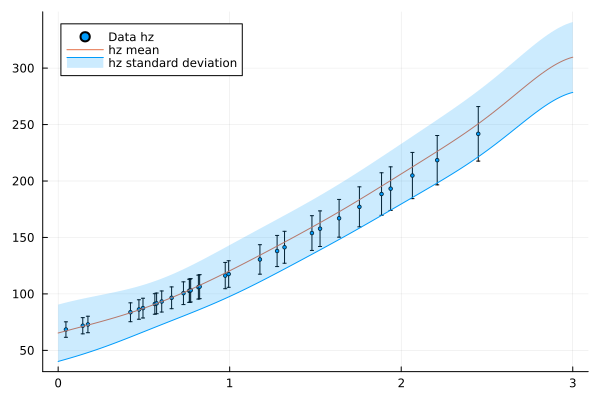

In [130]:
# integral space hz plot
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(z_integ, vec(hz_m2), label="hz mean")
plot!(z_integ, vec(hz_m2 .- hz_s2),  fillrange = vec(hz_m2 .+ hz_s2), fillalpha=0.2, c=1, label="hz standard deviation")

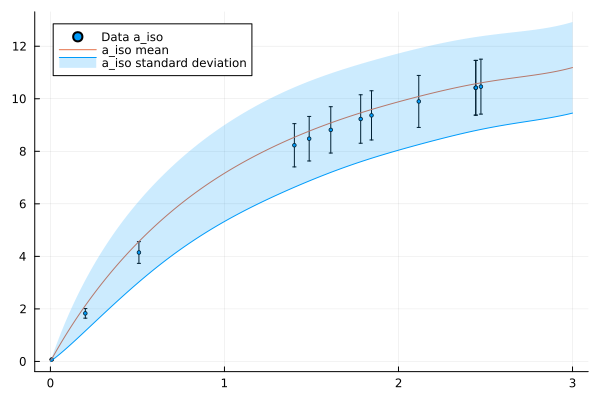

In [131]:
# integral space aiso plot
plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, label="Data a_iso", ms=2, seriestype=:scatter)
plot!(z_integ, vec(aiso_m2), label="a_iso mean")
plot!(z_integ, vec(aiso_m2 .- aiso_s2),  fillrange = vec(aiso_m2 .+ aiso_s2), fillalpha=0.2, c=1, label="a_iso standard deviation")

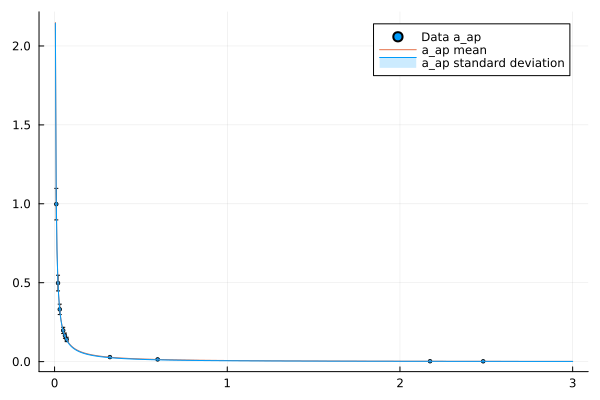

In [132]:
# plotting chi data 
plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, label="Data a_ap", ms=2, seriestype=:scatter)
plot!(z_integ, vec(aap_m2), label="a_ap mean")
plot!(z_integ, vec(aap_m2 .- aap_s2),  fillrange = vec(aap_m2 .+ aap_s2), fillalpha=0.2, c=1, label="a_ap standard deviation")

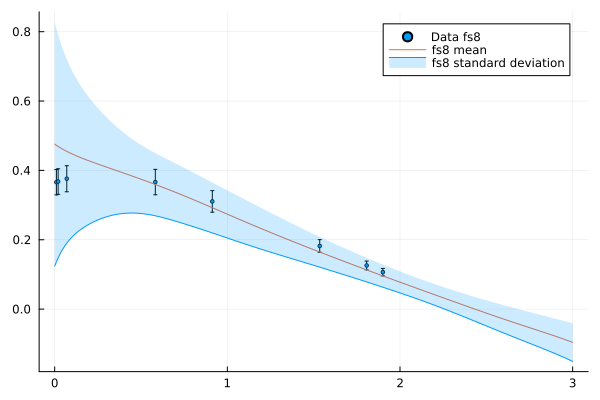

In [133]:
# plotting fs8 data 
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(z_integ, vec(fs8_m2), label="fs8 mean")
plot!(z_integ, vec(fs8_m2 .- fs8_s2),  fillrange = vec(fs8_m2 .+ fs8_s2), fillalpha=0.2, c=1, label="fs8 standard deviation")

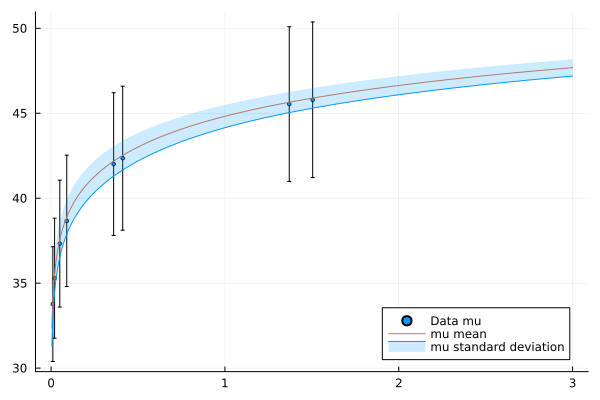

In [134]:
# plotting supernovae data 
plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, label="Data mu", ms=2, seriestype=:scatter)
plot!(z_integ, vec(mu_m2), label="mu mean")
plot!(z_integ, vec(mu_m2 .- mu_s2),  fillrange = vec(mu_m2 .+ mu_s2), fillalpha=0.2, c=1, label="mu standard deviation")

## GP modelling - posteriors

In [135]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors, parameters
    eta2 = 50
    l2 = 0.3
    v_po ~ MvNormal(zeros(length(X)), ones(length(X)))
    omegam_po ~ omegam_dist
    s8_po ~ s8_dist
    h_po ~ h0_dist
    r_po ~ rd_dist
    M_po ~ M_dist
    
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_po)
    mean_ez = Ez(cpar, X)
    ez_latent = latent_GP(mean_ez, v_po, kernel)
    ez_gp = conditional(X, int_grid, ez_latent, sqexp_cov_fn; eta=eta2, l=l2) # converting from latent space to integral space
    
    # sampling over parameters
    hz = hz_from_ez(int_grid, h_po, ez_gp);
    aiso = a_iso(int_grid, h_po, r_po, ez_gp);
    aap = a_ap(int_grid, h_po, ez_gp);
    fs8 = fs8_from_ez(int_grid, omegam_po, s8_po, h_po, ez_gp, eltype(ez_gp));
    mu_mod = mu(int_grid, h_po, M_po, ez_gp);

    hz_interp = LinearInterpolation(int_grid, hz, extrapolation_bc=Line())
    aiso_interp = LinearInterpolation(int_grid, aiso, extrapolation_bc=Line())
    aap_interp = LinearInterpolation(int_grid, aap, extrapolation_bc=Line())
    fs8_interp = LinearInterpolation(int_grid, fs8, extrapolation_bc=Line())
    mu_interp = LinearInterpolation(int_grid, mu_mod, extrapolation_bc=Line())

    hdata := hz_interp(fakedatahz.z)
    aisodata := aiso_interp(fakedataaiso.z)
    aapdata := aap_interp(fakedataaap.z)
    fs8data := fs8_interp(fakedatafs8.z)
    mudata := mu_interp(fakedatamu.z)
   

    datay = [hdata;aisodata;aapdata;fs8data;mudata]

    y ~ MvNormal(datay, data_cov) 

end

stats_model (generic function with 2 methods)

In [146]:
#init_params = [h_po => 0.7, omegam_po => 0.3]
chain_gp = sample(stats_model(data_obs), NUTS(nadapts, 0.65), nsamp)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   2%|▊                                         |  ETA: 0:05:59
Sampling   3%|█▍                                        |  ETA: 0:02:59
Sampling   5%|██▏                                       |  ETA: 0:02:02
Sampling   7%|██▊                                       |  ETA: 0:01:31
Sampling   8%|███▌                                      |  ETA: 0:01:14
Sampling  10%|████▎                                     |  ETA: 0:01:01
Sampling  12%|████▉                                     |  ETA: 0:00:54
Sampling  13%|█████▋                                    |  ETA: 0:00:47
Sampling  15%|██████▎                                   |  ETA: 0:00:42
Sampling  17%|███████                                   |  ETA: 0:00:38
Sampling  18%|███████▊                                  |  ETA: 0:00:34
Sampling  

Chains MCMC chain (50×115×1 Array{Float64, 3}):

Iterations        = 11:1:60
Number of chains  = 1
Samples per chain = 50
Wall duration     = 680.73 seconds
Compute duration  = 680.73 seconds
parameters        = v_po[1], v_po[2], v_po[3], v_po[4], v_po[5], v_po[6], v_po[7], v_po[8], v_po[9], v_po[10], v_po[11], v_po[12], v_po[13], v_po[14], v_po[15], v_po[16], v_po[17], v_po[18], v_po[19], v_po[20], v_po[21], v_po[22], v_po[23], v_po[24], v_po[25], v_po[26], v_po[27], v_po[28], v_po[29], v_po[30], omegam_po, s8_po, h_po, r_po, M_po, hdata[1], hdata[2], hdata[3], hdata[4], hdata[5], hdata[6], hdata[7], hdata[8], hdata[9], hdata[10], hdata[11], hdata[12], hdata[13], hdata[14], hdata[15], hdata[16], hdata[17], hdata[18], hdata[19], hdata[20], hdata[21], hdata[22], hdata[23], hdata[24], hdata[25], hdata[26], hdata[27], hdata[28], hdata[29], hdata[30], aisodata[1], aisodata[2], aisodata[3], aisodata[4], aisodata[5], aisodata[6], aisodata[7], aisodata[8], aisodata[9], aisodata[10], aisodata[

In [137]:
# data posterior gp chains
hdata_p = group(chain_gp, :hdata).value.data[:,:,1];
aisodata_p = group(chain_gp, :aisodata).value.data[:,:,1];
aapdata_p =  group(chain_gp, :aapdata).value.data[:,:,1];
fs8data_p =  group(chain_gp, :fs8data).value.data[:,:,1];
mudata_p =  group(chain_gp, :mudata).value.data[:,:,1];

# parameter chains
v_p = group(chain_gp, :v_po).value.data[:, :, 1];
omegam_p = group(chain_gp, :omegam_po).value.data[:, :, 1];
s8_p = group(chain_gp, :s8_po).value.data[:, :, 1];

In [138]:
# data mean / standard dev.
hpmean, hps = mean(hdata_p, dims=1), std(hdata_p, dims=1);
aisopmean, aisops = mean(aisodata_p, dims=1), std(aisodata_p, dims=1);
aappmean, aapps = mean(aapdata_p, dims=1), std(aapdata_p, dims=1);
fs8pmean, fs8ps = mean(fs8data_p, dims=1), std(fs8data_p, dims=1);
mupmean, mups = mean(mudata_p, dims=1), std(mudata_p, dims=1);

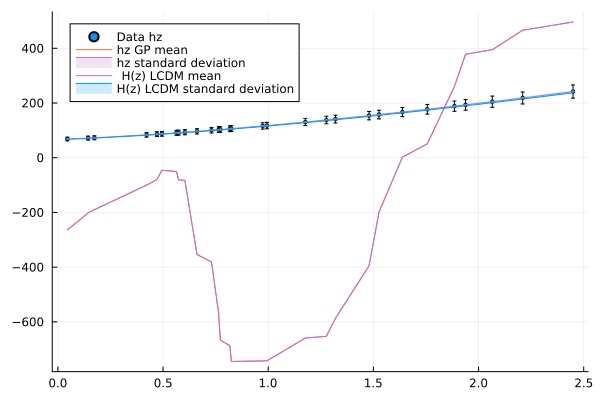

In [139]:
plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, label="Data hz", ms=2, seriestype=:scatter)
plot!(fakedatahz.z, vec(hpmean), label="hz GP mean")
plot!(fakedatahz.z, vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=4, label="hz standard deviation")
plot!(fakedatahz.z, vec(hz_lcdm_m), label=" H(z) LCDM mean")
plot!(fakedatahz.z, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="H(z) LCDM standard deviation")

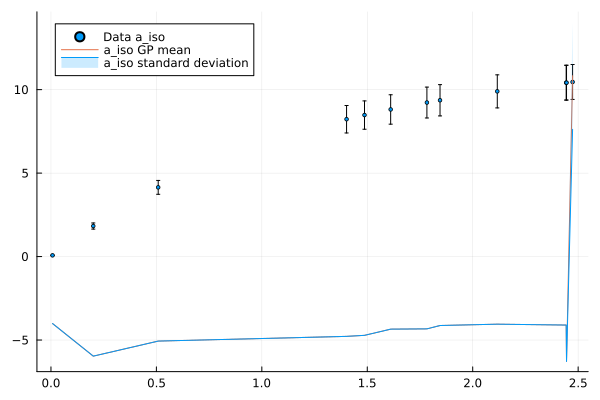

In [140]:
plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, label="Data a_iso", ms=2, seriestype=:scatter)
plot!(fakedataaiso.z, vec(aisopmean), label="a_iso GP mean")
plot!(fakedataaiso.z, vec(aisopmean .- aisops),  fillrange = vec(aisopmean .+ aisops), fillalpha=0.2, c=1, label="a_iso standard deviation")

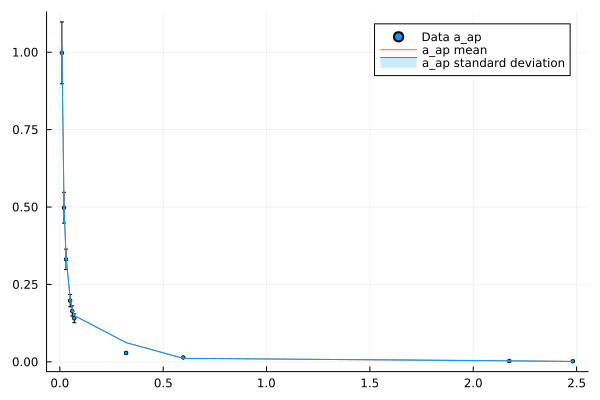

In [141]:
plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, label="Data a_ap", ms=2, seriestype=:scatter)
plot!(fakedataaap.z, vec(aappmean), label="a_ap mean")
plot!(fakedataaap.z, vec(aappmean .- aapps),  fillrange = vec(aappmean .+ aapps), fillalpha=0.2, c=1, label="a_ap standard deviation")

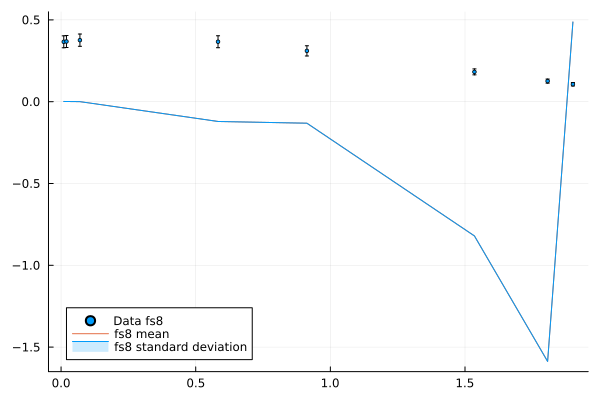

In [142]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8pmean), label="fs8 mean")
plot!(fakedatafs8.z, vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=1, label="fs8 standard deviation")

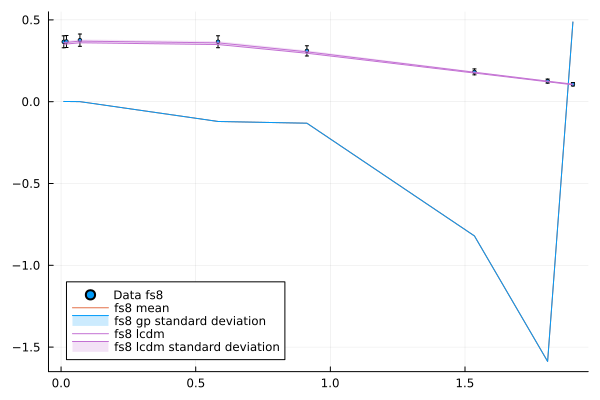

In [143]:
plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(fakedatafs8.z, vec(fs8pmean), label="fs8 mean")
plot!(fakedatafs8.z, vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=1, label="fs8 gp standard deviation")
plot!(fakedatafs8.z, vec(fs8_lcdm_m), label="fs8 lcdm")
plot!(fakedatafs8.z, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=4, label="fs8 lcdm standard deviation")

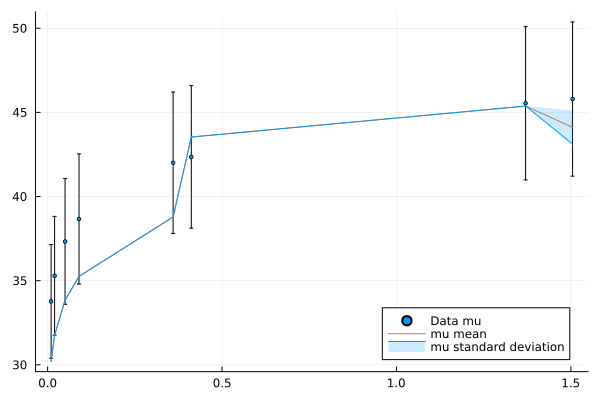

In [144]:
plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, label="Data mu", ms=2, seriestype=:scatter)
plot!(fakedatamu.z, vec(mupmean), label="mu mean")
plot!(fakedatamu.z, vec(mupmean .- mups),  fillrange = vec(mupmean .+ mups), fillalpha=0.2, c=1, label="mu standard deviation")

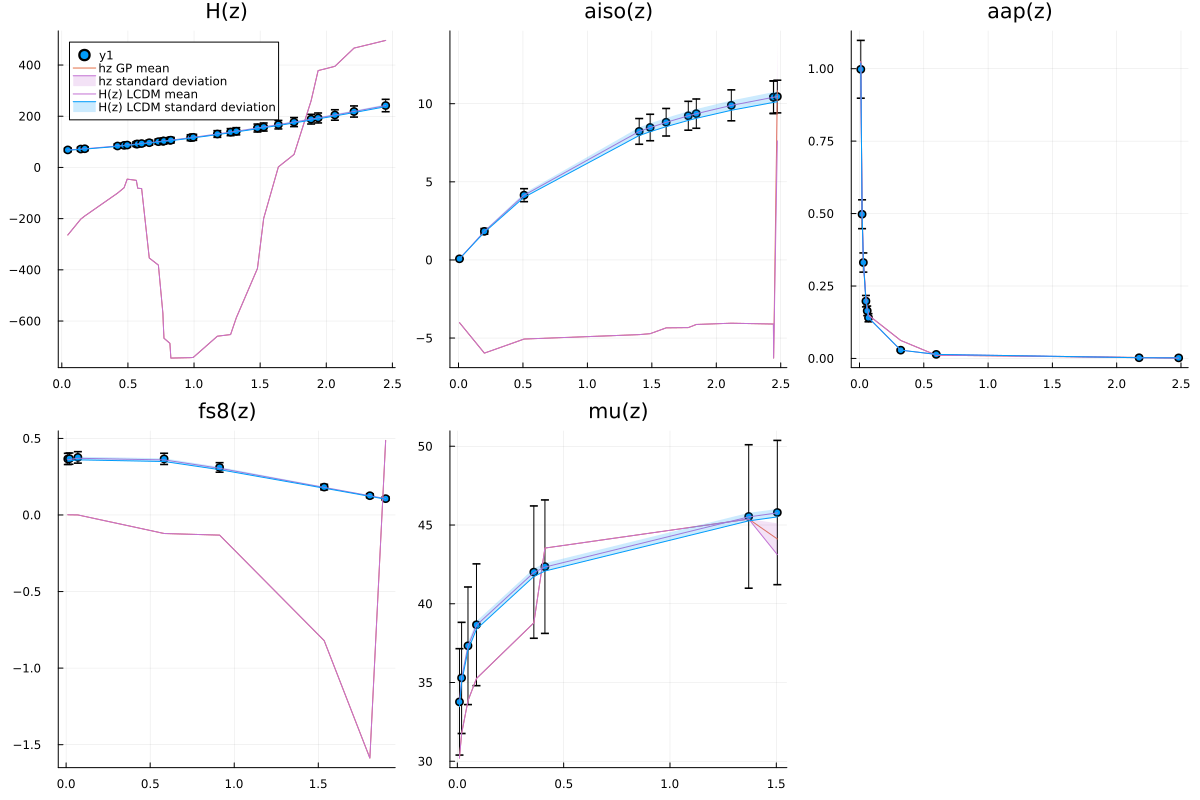

In [ ]:
p0 = plot(fakedatahz.z, fakedatahz.data, yerr=hz_err, seriestype=:scatter,label="H(z)")
p1 = plot(fakedataaiso.z, fakedataaiso.data, yerr=aiso_err, seriestype=:scatter,label="aiso(z)")
p2 = plot(fakedataaap.z, fakedataaap.data, yerr=aap_err, seriestype=:scatter, label="aap(z)")
p3 = plot(fakedatafs8.z, fakedatafs8.data, yerr=fs8_err, seriestype=:scatter, label="fs8(z)")
p4 = plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, seriestype=:scatter, label="mu(z)")


plot!(p0, fakedatahz.z, vec(hpmean), label="hz GP mean")
plot!(p0, fakedatahz.z, vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=4, label="hz standard deviation")
plot!(p0, fakedatahz.z, vec(hz_lcdm_m), label="H(z) LCDM mean")
plot!(p0, fakedatahz.z, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="H(z) LCDM standard deviation")


plot!(p1, fakedataaiso.z, vec(aisopmean), label="a_iso GP mean")
plot!(p1, fakedataaiso.z, vec(aisopmean .- aisops),  fillrange = vec(aisopmean .+ aisops), fillalpha=0.2, c=4, label="a_iso standard deviation")
plot!(p1, fakedataaiso.z, vec(aiso_lcdm_m), label="a_iso LCDM mean")
plot!(p1, fakedataaiso.z, vec(aiso_lcdm_m .- aiso_lcdm_s),  fillrange = vec(aiso_lcdm_m .+ aiso_lcdm_s), fillalpha=0.2, c=1, label="a_iso LCDM standard deviation")


plot!(p2, fakedataaap.z, vec(aappmean), label="a_ap GP mean")
plot!(p2, fakedataaap.z, vec(aappmean .- aapps),  fillrange = vec(aappmean .+ aapps), fillalpha=0.2, c=4, label="a_ap standard deviation")
plot!(p2, fakedataaap.z, vec(aap_lcdm_m), label="a_ap LCDM mean")
plot!(p2, fakedataaap.z, vec(aap_lcdm_m .- aap_lcdm_s),  fillrange = vec(aap_lcdm_m .+ aap_lcdm_s), fillalpha=0.2, c=1, label="a_ap LCDM standard deviation")


plot!(p3, fakedatafs8.z, vec(fs8pmean), label="fs8 GP mean")
plot!(p3, fakedatafs8.z, vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=4, label="fs8 standard deviation")
plot!(p3, fakedatafs8.z, vec(fs8_lcdm_m), label="fs8 LCDM mean")
plot!(p3, fakedatafs8.z, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=1, label="fs8 LCDM standard deviation")


plot!(p4, fakedatamu.z, vec(mupmean), label="mu GP mean")
plot!(p4, fakedatamu.z, vec(mupmean .- mups),  fillrange = vec(mupmean .+ mups), fillalpha=0.2, c=4, label="mu standard deviation")
plot!(p4, fakedatamu.z, vec(mu_lcdm_m), label="mu LCDM mean")
plot!(p4, fakedatamu.z, vec(mu_lcdm_m .- mu_lcdm_s),  fillrange = vec(mu_lcdm_m .+ mu_lcdm_s), fillalpha=0.2, c=1, label="mu LCDM standard deviation")

plot(p0, p1, p2, p3, p4, layout=(2,3), size=(1600,1000))